In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('result/all-result/AUC_All_los_pred.csv')
grouped_df = df.groupby('Number of Modalities')['AUCROC_mean'].mean().reset_index()

grouped_df

,Number of Modalities,AUCROC_mean
0,1.0,0.848728
1,2.0,0.867550
2,3.0,0.873234
3,4.0,0.873628


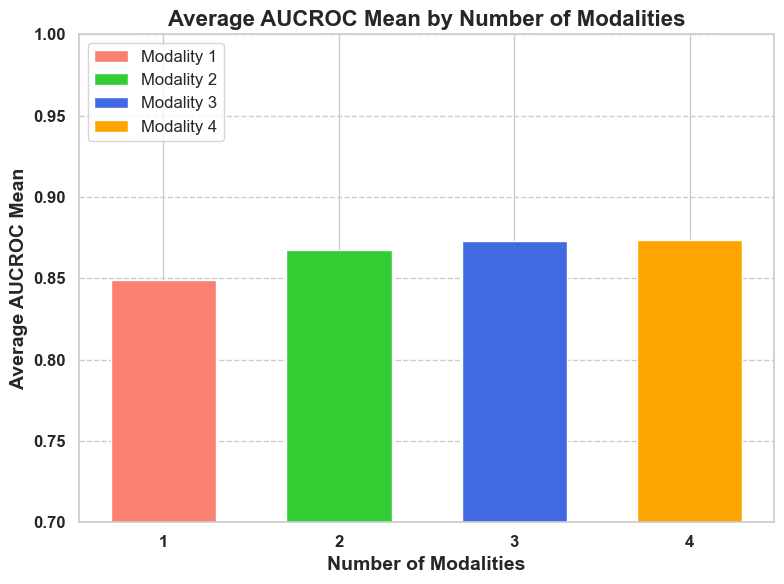

In [28]:
# Colors for each bar
colors = ['#FA8072', '#32CD32', '#4169E1', '#FFA500']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(grouped_df['Number of Modalities'].astype(int), grouped_df['AUCROC_mean'], color=colors, width=0.6)
plt.xlabel('Number of Modalities', fontsize=14, fontweight='bold')
plt.ylabel('Average AUCROC Mean', fontsize=14, fontweight='bold')
plt.title('Average AUCROC Mean by Number of Modalities', fontsize=16, fontweight='bold')
plt.xticks(grouped_df['Number of Modalities'].astype(int), fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylim(0.7, 1)
plt.grid(axis='y', linestyle='--')

# Adding the legend
plt.legend(bars, [f'Modality {i}' for i in grouped_df['Number of Modalities'].astype(int)], loc='upper left', fontsize=12)

plt.tight_layout()

plt.savefig('result/average_auc_by_modalities.png',dpi=300)
plt.show()


In [29]:
df = pd.read_csv('result/all-result/AUC_All_los_pred.csv')
grouped_df = df.groupby('Number of Sources')['AUCROC_mean'].mean().reset_index()

grouped_df

,Number of Sources,AUCROC_mean
0,1,0.782120
1,2,0.843222
2,3,0.872387
3,4,0.880249


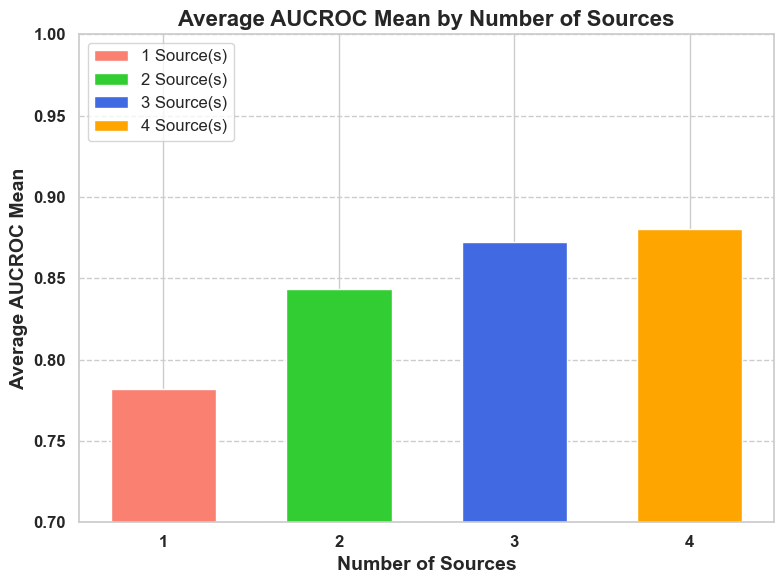

In [31]:
# Colors for each bar
colors = ['#FA8072', '#32CD32', '#4169E1', '#FFA500']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(grouped_df['Number of Sources'].astype(int), grouped_df['AUCROC_mean'], color=colors, width=0.6)
plt.xlabel('Number of Sources', fontsize=14, fontweight='bold')
plt.ylabel('Average AUCROC Mean', fontsize=14, fontweight='bold')
plt.title('Average AUCROC Mean by Number of Sources', fontsize=16, fontweight='bold')
plt.xticks(grouped_df['Number of Sources'].astype(int), fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylim(0.7, 1)
plt.grid(axis='y', linestyle='--')

# Adding the legend
plt.legend(bars, [f'{i} Source(s)' for i in grouped_df['Number of Sources'].astype(int)], loc='upper left', fontsize=12)

plt.tight_layout()

plt.savefig('result/average_auc_by_sources.png',dpi=300)
plt.show()

In [35]:
# shap value
from itertools import chain, combinations
from math import comb
import pandas as pd

In [39]:
df = pd.read_csv('result/all-result/AUC_All_los_pred.csv')
df = df[['AUCROC_mean','viz', 'txt', 'tab', 'ts']]

In [41]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2,) (1,3,) (2,3,) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# 假设我们有一个函数`model_predict`，它根据给定的特征组合返回AUCROC_mean。
# 定义一个函数来计算特征子集的平均AUCROC_mean
def model_predict(features):
    # 根据特征子集过滤数据，确保仅选定特征为1，其他为0
    query_parts = [f'{feature} == 1' for feature in features]
    other_features = set(df.columns) - set(features) - {'AUCROC_mean'}
    query_parts.extend([f'{feature} == 0' for feature in other_features])
    query = ' & '.join(query_parts)

    subset_df = df.query(query)

    # 计算平均AUCROC_mean值
    if not subset_df.empty:
        return subset_df['AUCROC_mean'].mean()
    else:
        return None

In [42]:
model_predict(['viz'])

0.8599515484370933

In [43]:
# 特征列表
features = ['viz', 'txt', 'tab', 'ts']

# 计算Shapley值
shapley_values = {feature: 0 for feature in features}
for feature in features:
    for subset in powerset(set(features) - {feature}):
        subset_with_feature = subset + (feature,)
        shapley_values[feature] += (
            model_predict(subset_with_feature) -
            model_predict(subset)
        ) / comb(len(features), len(subset_with_feature))


In [44]:
shapley_values

{'viz': 0.06582155741264054,
 'txt': -0.013653904942904766,
 'tab': -0.024929118848081012,
 'ts': 0.08512749297417999}

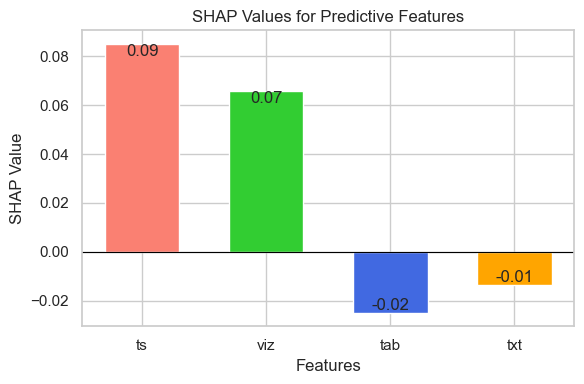

In [48]:
shap_values = {'viz': 0.06582155741264054,
               'txt': -0.013653904942904766,
               'tab': -0.024929118848081012,
               'ts': 0.08512749297417999}

shap_values_sorted = dict(sorted(shap_values.items(), key=lambda item: abs(item[1]), reverse=True))

# Creating the plot
plt.figure(figsize=(6, 4))
colors = ['#FA8072', '#32CD32', '#4169E1', '#FFA500']
bars = plt.bar(range(len(shap_values_sorted)), list(shap_values_sorted.values()), color=colors,width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom' if yval < 0 else 'top', ha='center')

plt.xticks(range(len(shap_values_sorted)), list(shap_values_sorted.keys()))

plt.xlabel('Features')
plt.ylabel('SHAP Value')
plt.title('SHAP Values for Predictive Features')
plt.axhline(0, color='black', linewidth=0.8)  # Add horizontal line at zero

plt.tight_layout()

plt.savefig('result/shap_value_los.png',dpi=300)
plt.show()
